## Figuras 47 Tucanae

In [106]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
from dotenv import load_dotenv
from google.cloud import storage

import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

    
# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.sources.source import AstroMetricData, AstroObject
from hyper_velocity_stars_detection.jobs.utils import read_baumgardt_catalog
from hyper_velocity_stars_detection.globular_clusters import GlobularClusterAnalysis
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_globular_cluster
from hyper_velocity_stars_detection.variables_names import *

load_dotenv("../../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../data/hvs-storage.json"

PATH = "../../data/report_notebook"

RADIUS_SCALE = 1
CATALOG = "gaiadr3"
FILTERS = {"ast_params_solved": 3, "ruwe": 1.4, "v_periods_used": 10, "min_parallax": 0}
PROJECT = os.environ["PROJECT_ID"]
BUCKET = os.environ["BUCKET"]
BUCKET_PATH = "report/gc_clusters/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Descarga del cúmulo analizado

In [65]:
CLUSTER_NAME = "ngc 104"

gc_object = load_globular_cluster(CLUSTER_NAME, PROJECT, BUCKET, BUCKET_PATH)
print(gc_object)

Muestras seleccionadas del objeto astronómico ngc 104 con radio 1.0:
	 - df_c1 - Todas las estrellas seleccionadas: 96405.
	 - df_c2 - Las estrellas con errores de paralaje y pm menores al 10%: 16239.
	 - df_c3 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16239.
	 - df_c4 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 23393.
Se han encontrado 37 fuentes de rayos X.
Estimated number of clusters: 3
Estimated number of noise points: 1552
	 - Volumen total del cluster 0: 154.
	 - Volumen total del cluster 1: 2658.
	 - Volumen total del cluster 2: 636.



## Figura fracción descartada de estrellas por filtros

Descargamso los datos sin filtrar para estimar el volumen descartado.

In [107]:
astro_object = AstroObject.get_object("ngc 104")
radius = astro_object.info["ANGULAR_SIZE"][0] / 60
df_tuc =  astro_object.download_data(
        radius=radius,
        catalog_name="gaiadr3",
        ast_params_solved=None,
        ruwe=None,
        v_periods_used=None
    )
astro_data

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


NameError: name 'astro_data' is not defined

In [70]:
df_data = gc_object.astro_data.get_data("df_c1")
df_descarted = df_tuc[~df_tuc.SOURCE_ID.isin(df_data.SOURCE_ID)]
df_descarted

/tmp/ipykernel_39362/521407414.py:1: RuntimeWarning: invalid value encountered in divide
  descarted_stars / original_stars


array([       nan, 0.96174863, 0.95577558, 0.94265445, 0.91654123,
       0.89358523, 0.86454948, 0.83769605, 0.81044234, 0.78526694,
       0.75641526, 0.73118736, 0.70485819, 0.68206055, 0.66112941,
       0.64222787, 0.62450884, 0.60829657, 0.5937971 , 0.58269599,
       0.57262905, 0.56364428, 0.55547688, 0.54769773, 0.54093693,
       0.53489111, 0.52937428, 0.52452869, 0.52005719, 0.51620368,
       0.51255709, 0.50918335, 0.50623561, 0.50342492, 0.50111018,
       0.49875752, 0.49666082, 0.49501539, 0.49321627, 0.49178338,
       0.49037155, 0.48911264, 0.48813128, 0.48682039, 0.48601198,
       0.48502986, 0.48413621, 0.48330937, 0.48256215, 0.48185642,
       0.48141463, 0.48097581, 0.48052084, 0.48016835, 0.47981693,
       0.4794884 , 0.47912038, 0.47946787, 0.4800485 , 0.47993219,
       0.47956444, 0.47951781, 0.47937471, 0.47907651, 0.47907516,
       0.4788876 , 0.47868807, 0.47893321, 0.47925343, 0.47923448,
       0.47915832, 0.47916979, 0.47914511, 0.47903551, 0.47893

/tmp/ipykernel_39362/2795064878.py:17: RuntimeWarning: invalid value encountered in divide
  ratio_descarted_2 =descarted_stars/ original_stars


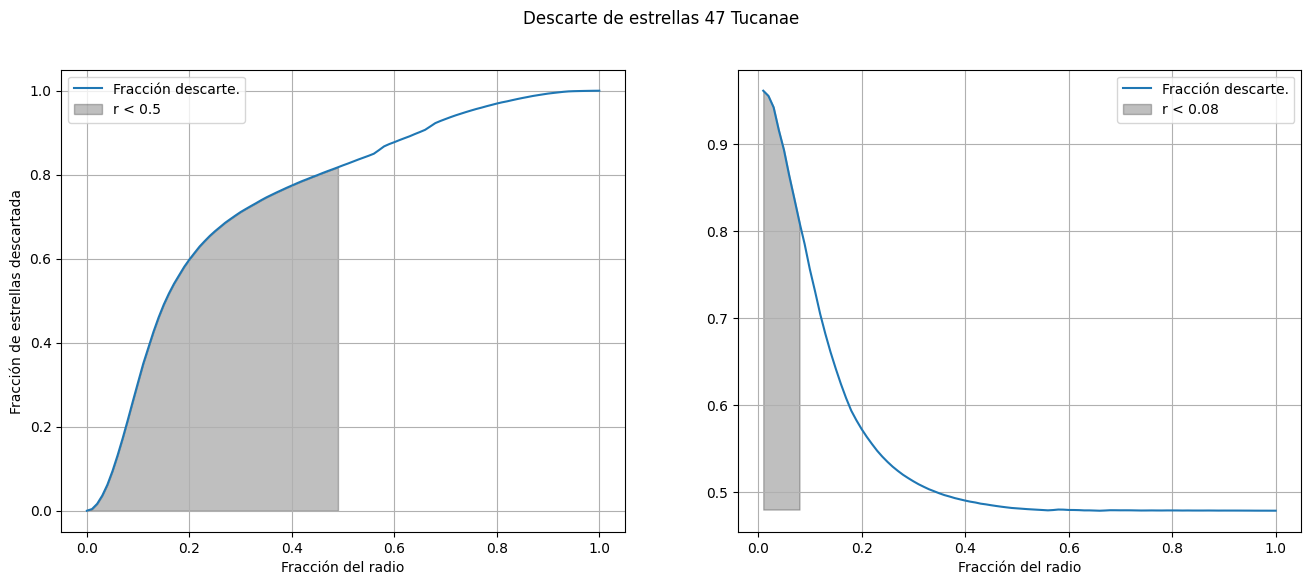

In [126]:
def count_star(center: np.ndarray, df_data: pd.DataFrame, radio: float) -> int:
    distance = np.sqrt((df_data.l - center[0])**2 + (df_data.b - center[1])**2)
    distance = distance / distance.max()
    return (distance<radio).sum()

center = np.array([df_data.l.mean(), df_data.b.mean()])
count_star(center, df_descarted, 0.5)

radio_array = np.linspace(0, 1, 101)
original_stars = np.zeros(101)
descarted_stars = np.zeros(101)
for pos, radio in enumerate(radio_array):
    original_stars[pos] = count_star(center, df_tuc, radio)
    descarted_stars[pos] = count_star(center, df_descarted, radio)

ratio_descarted =descarted_stars/ df_descarted.shape[0]
ratio_descarted_2 =descarted_stars/ original_stars
#plt.plot(radio_array, ratio_descarted)
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Descarte de estrellas 47 Tucanae")
ax[0].plot(radio_array, ratio_descarted, label="Fracción descarte.")
ax[0].fill_between(x=radio_array[radio_array<0.5], y1=0, y2=ratio_descarted[radio_array<0.5], color="k", alpha=0.25, label="r < 0.5")
ax[0].set_xlabel("Fracción del radio")
ax[0].set_ylabel("Fracción de estrellas descartada")
ax[0].legend()
ax[0].grid()


ax[1].plot(radio_array, ratio_descarted_2, label="Fracción descarte.")
mask = ratio_descarted_2 > 0.8
ax[1].fill_between(x=radio_array[mask], y1=0.48, y2=ratio_descarted_2[mask], color="k", alpha=0.25, label=f"r < {radio_array[mask].max():.2f}")
ax[1].set_xlabel("Fracción del radio")
ax[1].legend()
ax[1].grid()
plt.savefig("../figures/fraccion_descarte_47tucanae.png")


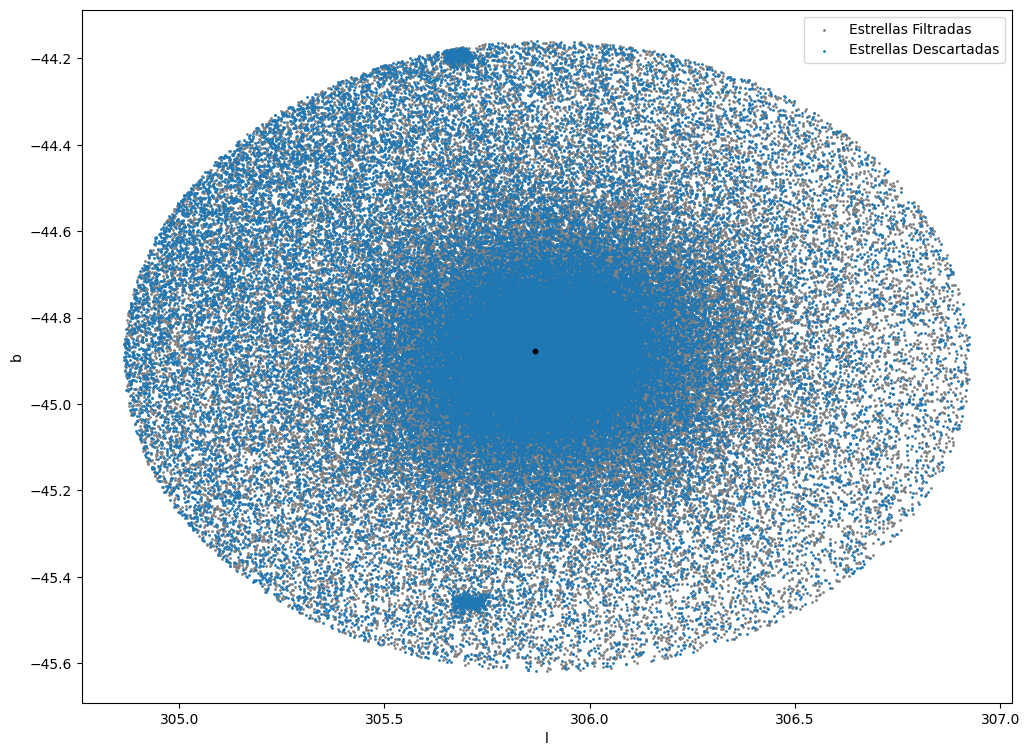

In [93]:
ax = df_data.plot.scatter(x="l", y="b", s=1, color="grey", figsize=(12, 9), label="Estrellas Filtradas")
df_descarted.plot.scatter(ax=ax, x="l", y="b", s=1, label="Estrellas Descartadas")
ax.scatter(x=np.array([df_data.l.mean()]), y=np.array([df_data.b.mean()]), s=10, color="k")

'https://sky.esa.int/esasky/?target=305.88309679902136%20-44.89619341045216&hips=DSS2+color&fov=1.5412867810412323&projection=SIN&cooframe=GALACTIC&sci=false&lang=es'

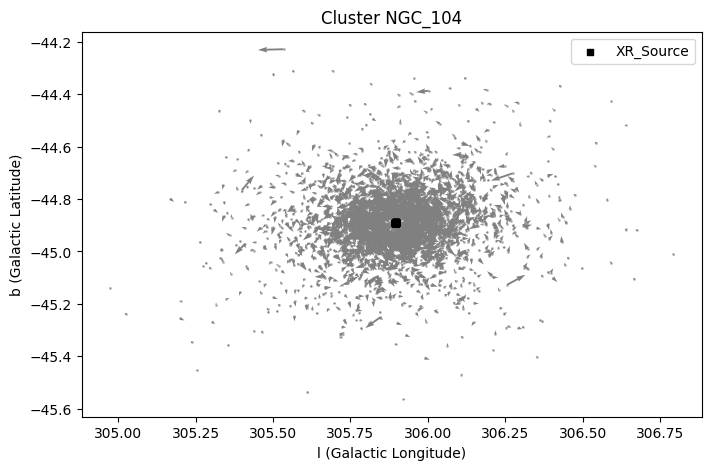

In [62]:
fig, ax = gc_object.plot_cluster(factor_size=10)
lmin, lmax = ax.get_xlim() 
bmin, bmax = ax.get_ylim() 

l0  = 0.5*(lmin + lmax)
b0  = 0.5*(bmin + bmax)
dl  = (lmax - lmin)
db  = (bmax - bmin)

width_eff  = dl * np.cos(np.deg2rad(abs(b0)))  # grados
height_eff = db                                # grados
fov = max(width_eff, height_eff) * 1.05        # margen 5%

URL = f"https://sky.esa.int/esasky/?target={l0}%20{b0}&hips=DSS2+color&fov={fov}&projection=SIN&cooframe=GALACTIC&sci=false&lang=es"
URL

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/astropy/visualization/lupton_rgb.py:305: RuntimeWarning: invalid value encountered in divide
  fInorm = np.where(Int <= 0, 0, np.true_divide(fI, Int))


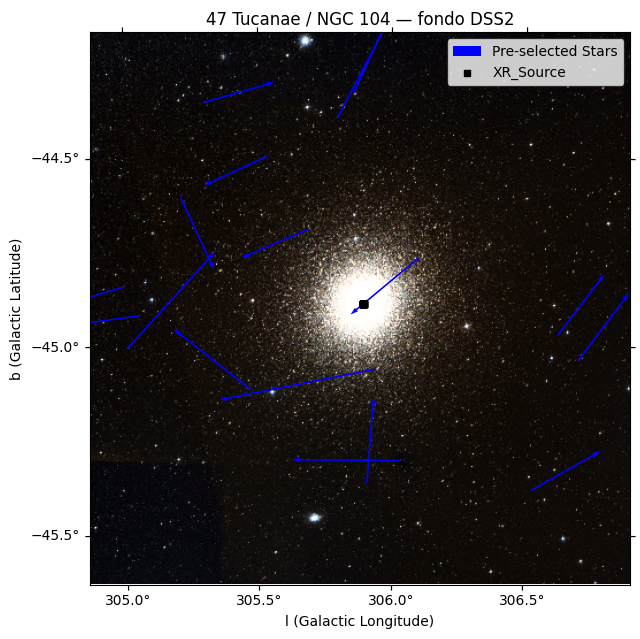

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb


# se ha extraido de https://aladin.cds.unistra.fr/AladinLite/
file = "/home/santhiperbolico/Descargas/cutout-CDS_P_DSS2_color (4).fits"

# 1) Abrir el HDU que tiene datos 2D/3D (a veces es [1] y no [0])
hdul = fits.open(file)
# Busca el primer HDU con datos de al menos 2D
hdu = next(h for h in hdul if hasattr(h, "data") and isinstance(h.data, np.ndarray) and h.data.ndim >= 2)

# 2) WCS celestial (solo los ejes del cielo)
wcs_full = WCS(hdu.header)
wcs = wcs_full.celestial  # <-- esto evita el error de "más de 2 dimensiones"

# 3) Imagen 2D a partir del cubo:
data = hdu.data
r_ch, g_ch, b_ch = data[0], data[1], data[2]

def clip01(img, p_lo=1, p_hi=99.5):
    vmin, vmax = np.nanpercentile(img, [p_lo, p_hi])
    img = np.clip((img - vmin) / (vmax - vmin + 1e-12), 0, 1)
    return img

r = clip01(r_ch, 1, 99.9)
g = clip01(g_ch, 1, 99.9)
b = clip01(b_ch, 1, 99.9)

# --- composición RGB con asinh (Lupton) ---
# Q y stretch controlan el contraste global (ajústalos si quieres)
rgb = make_lupton_rgb(r, g, b, Q=1, stretch=0.8)

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(projection=wcs)
ax.imshow(rgb, origin="lower")

ax.coords[0].set_format_unit(u.deg, decimal=True)
ax.coords[1].set_format_unit(u.deg, decimal=True)
ax.invert_xaxis()

df_gc = gc_object.df_stars
df_source_x = gc_object.xrsource.data
df_source_x = df_source_x[df_source_x.main_id == gc_object.name]
factor_size = 15
hvs_kms = 200


tr = ax.get_transform('galactic')
lon = ax.coords[0];
lat = ax.coords[1]
lon.set_format_unit(u.deg, decimal=True)
lat.set_format_unit(u.deg, decimal=True)
lon.set_axislabel("l (Galactic Longitude)")
lat.set_axislabel("b (Galactic Latitude)")


mean_pm_l = df_gc["pm_l"].mean()
mean_pm_b = df_gc["pm_b"].mean()

mean_pm_ra_kms = df_gc["pmra_kms"].mean()
mean_pm_dec_kms = df_gc["pmdec_kms"].mean()

df_highlights_stars = gc_object.astro_data.get_data("df_c2")
df_highlights_stars["pm_kms"] = np.sqrt((df_highlights_stars.pmra_kms - mean_pm_ra_kms)**2 + (df_highlights_stars.pmdec_kms - mean_pm_dec_kms)**2)
df_highlights_stars = df_highlights_stars[
    (df_highlights_stars.parallax >= df_gc.parallax.mean() - 1* df_gc.parallax.std()) &
    (df_highlights_stars.parallax <= df_gc.parallax.mean() + 1* df_gc.parallax.std()) &
    (df_highlights_stars.pm_kms >= hvs_kms) & 
    (df_highlights_stars.ipd_gof_harmonic_amplitude <0.15)& 
    (df_highlights_stars.ipd_frac_multi_peak <10)
]


ax.quiver(
    df_highlights_stars.l* u.deg,
    df_highlights_stars.b* u.deg,
    (df_highlights_stars.pm_l - mean_pm_l) / factor_size,
    (df_highlights_stars.pm_b - mean_pm_b) / factor_size,
    color="blue",
    scale=5,
    width=0.003,
    label="Pre-selected Stars",
    transform=tr,
)

ax.scatter(
    df_source_x.lii.values* u.deg,
    df_source_x.bii.values* u.deg,
    marker="s",
    s=20,
    color="k",
    label="XR_Source",
    transform=tr,
)

# --- 2) Esquinas del rectángulo en (l,b) -> ICRS (RA/Dec) ---
corners_gal = SkyCoord(
    l=[lmin, lmax, lmin, lmax]*u.deg,
    b=[bmin, bmax, bmax, bmin]*u.deg,
    frame="galactic"
)
corners_icrs = corners_gal.icrs

# --- 3) RA/Dec -> píxeles con el WCS 2D que usaste en projection=wcs ---
# (suponiendo que 'wcs' es el WCS celestial del FITS: wcs = WCS(hdu.header).celestial)
xp, yp = wcs.world_to_pixel(corners_icrs)

# --- 4) Fijar límites en píxeles (zoom) ---
ax.set_xlim(np.max(xp), np.min(xp))
ax.set_ylim(np.min(yp), np.max(yp))

ax.set_title("47 Tucanae / NGC 104 — fondo DSS2")
ax.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.show()